In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


import string
from string import digits
import re
import io
import tarfile
import urllib.request
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, TextVectorization
from keras.models import Model
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

**TASK 1**

In [2]:
NMT_eng = pd.read_csv("../input/nmp-en-ro/en.txt", engine='python', sep='/n', on_bad_lines='warn', skiprows = 0,nrows=20_000, header=None, names = ['source']) #370_000 - max
NMT_ro = pd.read_csv("../input/nmp-en-ro/ro.txt",engine='python', sep='/n', on_bad_lines='warn', skiprows = 0,nrows=20_000, header=None, names = ['target'])  #370_000 - max
lines = NMT_eng
lines['target'] = NMT_ro
print(NMT_eng.shape[0], NMT_ro.shape[0])
lines.head(10)

20000 20000


,source,target
0,Membership of Parliament: see Minutes,Componenţa Parlamentului: a se vedea procesul-...
1,Approval of Minutes of previous sitting: see M...,Aprobarea procesului-verbal al şedinţei preced...
2,Membership of Parliament: see Minutes,Componenţa Parlamentului: a se vedea procesul-...
3,Verification of credentials: see Minutes,Verificarea prerogativelor: a se vedea procesu...
4,Documents received: see Minutes,Depunere de documente: a se vedea procesul-verbal
5,Written statements and oral questions (tabling...,Declaraţii scrise şi întrebări orale (depunere...
6,Petitions: see Minutes,Petiţii: a se vedea procesul-verbal
7,Texts of agreements forwarded by the Council: ...,Transmiterea de către Consiliu a textelor acor...
8,Action taken on Parliament's resolutions: see ...,Cursul dat rezoluţiilor Parlamentului: a se ve...
9,Agenda for next sitting: see Minutes,Ordinea de zi a următoarei şedinţe: a se vedea...


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ')])
    return text
X_ = lines['source'].apply(lambda x: clean_text(x))
y_ = lines['target'].apply(lambda x: clean_text(x))
y_ = "[start] " + y_ + " [end]"

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.1)

y_.head(10)

0    [start] componenţa parlamentului a se vedea pr...
1    [start] aprobarea procesului verbal al şedinţe...
2    [start] componenţa parlamentului a se vedea pr...
3    [start] verificarea prerogativelor a se vedea ...
4    [start] depunere de documente a se vedea proce...
5    [start] declaraţii scrise şi întrebări orale d...
6     [start] petiţii a se vedea procesul verbal [end]
7    [start] transmiterea de către consiliu a texte...
8    [start] cursul dat rezoluţiilor parlamentului ...
9    [start] ordinea de zi a următoarei şedinţe a s...
Name: target, dtype: object

In [4]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [5]:
vocab_size = 15000
sequence_length = 20
batch_size = 256

In [6]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,)
ro_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length + 1, standardize=custom_standardization,)
eng_vectorization.adapt(X_train)
ro_vectorization.adapt(y_train)

def format_dataset(eng, ro):
    eng = eng_vectorization(eng)
    ro = ro_vectorization(ro)
    return ({"encoder_inputs": eng, "decoder_inputs": ro[:, :-1],}, ro[:, 1:])


def make_dataset(X, y):
    eng_texts, ro_texts = X, y
    eng_texts = list(eng_texts)
    ro_texts = list(ro_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ro_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_test, y_test)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [7]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [8]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

In [9]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

In [10]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile("rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3845120     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    3155456     positional_embedding[0][0]       
________________________________________________________________________________________

In [11]:
ro_vocab = ro_vectorization.get_vocabulary()
ro_index_lookup = dict(zip(range(len(ro_vocab)), ro_vocab))
max_decoded_sentence_length = 20

In [12]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ro_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ro_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence[7:-5]

In [13]:
counter = 0
for i in X_test:
    counter+=1
    if counter > 50:
        break
    input_sentence = i
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print("--->")
    print(translated)
    print('___________________________')

although eu internal market legislation has mainly addressed commercial air transport it is worth noting that issues to do with general and business aviation are tending to crop up more and more in areas such as climate policy protection of the environment and aviation safety 
--->
 deşi piaţa internă în domeniul protecţiei consumatorilor legislaţia privind transportul cu animale este pus în pericol în mod esenţi
___________________________
many of us believe that this is not the way forward but you have taken the decision to subordinate your own country to something that must be considered jointly 
--->
 mulţi dintre noi nu cred că aceasta nu se poate prezenta poziţia dar aţi avut de a se ajun
___________________________
the first reason is the instability within the ruling coalition in the czech republic 
--->
 primul este acela de a se referă la principiile de republica cehă 
___________________________
as a country dependent on oil and gas imports and as a former eastern bloc count

**TASK 2**


4431872/4422102 [==============================] - 0s 0us/step


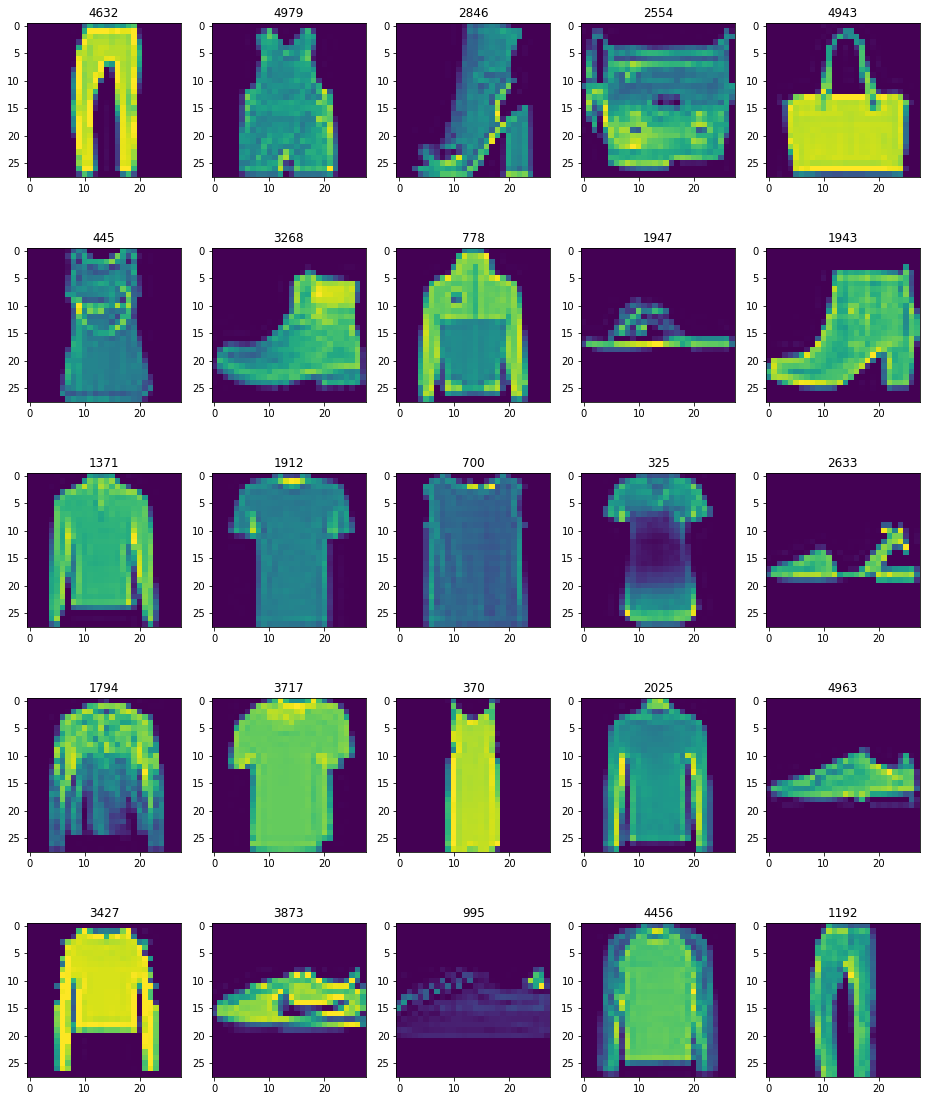

In [14]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() #train - 60_000 of 28x28 imgs, test - 10_000 of 28x28 imgs

# X_train = X_train_full[y_train_full == 0 or y_train_full == 1]
X_train = X_train_full[:5000] / 255.0
y_train = y_train_full[:5000]
X_test = X_test[:5000] / 255.0
y_test = y_test[:5000]
# print(X_train.shape)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

n_rows, n_cols = 5, 5
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,20))
for i in range(n_rows):
    for j in range(n_cols):
        n = np.random.randint(0, X_train.shape[0])
        ax[i,j].imshow(X_train[n])
        ax[i,j].set_title(n)
plt.show()

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_train = X_train * 2 - 1
X_test = X_test * 2 - 1


In [16]:
discriminator =  keras.Sequential()
discriminator.add(layers.Dense(1024, input_dim=X_train.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Dense(512))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Dense(256))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


In [17]:
latent_dim = 100
generator =  keras.Sequential()
generator.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(layers.LeakyReLU(alpha=0.2))

generator.add(layers.Dense(512))
generator.add(layers.LeakyReLU(alpha=0.2))

generator.add(layers.Dense(1024))
generator.add(layers.LeakyReLU(alpha=0.2))

generator.add(layers.Dense(X_train.shape[1], activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

In [18]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

In [19]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure(figsize=(10,12))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [20]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(X_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
             # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


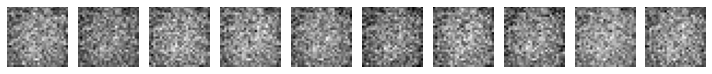

epoch:  20


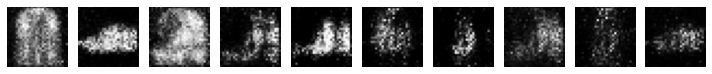

epoch:  40


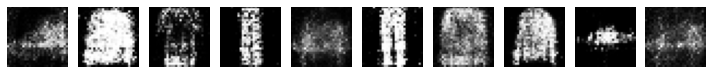

epoch:  60


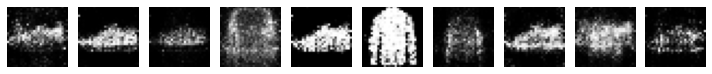

epoch:  80


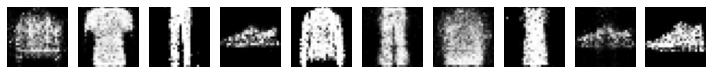

epoch:  100


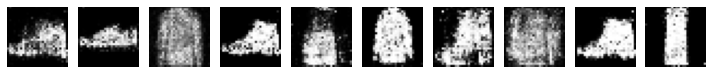

In [21]:
epochs = 100 #200 is cooler but slower
batch_size = 128
train_model(epochs, batch_size)